# Homework 3
## Machine Learning
## Sen Wang

In [2]:
!pip install mat4py

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import optimize, linalg
from mat4py import loadmat

import ipdb as debugger

# Problem 1: Robust Linear Regression


In [627]:
# load data
p1_data = loadmat('HW3_data/P1/P1.mat')
# unpack data
Xtrain = np.array(p1_data['Xtrain'])
Xtest = np.array(p1_data['Xtest'])
y = np.array(p1_data['y'])
dof = p1_data['dof']
sigma2 = p1_data['sigma2']

In [628]:
p1_data.keys()

dict_keys(['dof', 'sigma2', 'y', 'Xtrain', 'Xtest'])

## Part 1: Linear regression with least squares
As we have proven from the previous homework, the solution for the coefficients in linear regression is expressed as below, 

$\mathbf{w} = (\Phi_c^T\Phi)c)^{-1}\Phi_c\mathbf{t}_c$, where MLE of $w_0 = \bar{t} - \bar{\Phi}^T\mathbf{w}$

Note that the plot is compiled together with the rest of the problem. 

In [629]:
X = Xtrain
X_mean = np.mean(X, axis=0)
X_c = X - X_mean

y_mean = np.mean(y)
y_c = y - y_mean

In [630]:
w1_ls = np.squeeze(np.linalg.inv(X_c.T @ X_c) @ X_c.T @ y_c)
w0_ls = np.squeeze(y_mean - X_mean * w1_ls)

## Part 2: Linear regression with heavy tails
When Laplace distribution instead of Gaussian distribution is used for the likelihood, the new likelihood is expressed as below,

$p(\mathcal{D}|\mathbf{w}) = \prod_n^N\frac{1}{N}\frac{1}{2b}\exp(-\frac{|w_0 + w_1x_n - y_n|}{b})$

If we take derivative of the log-likelihood with respect to $\mathbf{w}$, provided data are centered, the error function is then, 

$\frac{dE(w_1)}{dw_1} = \sum_n^N|w_1\hat{x}_{n} - \hat{y}_n|$

where,

$\begin{align}
    \hat{x}_n &= x_n - \bar{x}\\
    \hat{y}_n &= y_n - \bar{y}
\end{align}
$

And the bias is obtained as simply $w_0 = \bar{y} - w_1\bar{x}$

Solution requires linear programming of the form: 
$r_i \triangleq r_i^+ - r_i^-$

$\min_{\mathbf{w}, r_i^+, r_i^-}\sum_{i}(r_i^++r_i^-)\ \text{  s.t.  } r_i^+\geq 0,r_i^-\geq 0, \mathbf{w}^T\mathbf{x_i} + r_i^+-r_i^- = t_i$

and 

$r_i^+ = \frac{1}{2}(r_i + |r_i|), r_i^- = \frac{1}{2}(|r_i|-r_i), |r_i| = r_i^+ + r_i^-$

The algorithm is applied with `scipy.optimize.linprog` and variables named according to [documentation convention](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.linprog.html).



In [634]:
# construt linear programming variables
N = Xtrain.shape[0]
c = np.concatenate([np.array([0,0]), np.ones(2*N)])
A_eq = np.concatenate([np.ones((N,1)),X, np.eye(N), -np.eye(N)], axis=1)
b_eq = y.reshape(y.shape[0])
bounds = [(None, None),(None, None)]+[(0,None) for i in range(2*N)]
res = optimize.linprog(c, A_eq=A_eq, b_eq=b_eq, bounds=bounds, options={'disp':True})
w1_la = res.x[1]
w0_la = res.x[0]

Optimization terminated successfully.
         Current function value: 23.555874   
         Iterations: 31


## Part 3: Huber Loss function
Using gradient descent method, the gradient can be calculated as, 
$\nabla L_H = \begin{cases}\begin{pmatrix}w_0 + w_1x_i - y_i \\ w_0x_i + w_1x_i^2 - y_ix_i \end{pmatrix}\ \ \text{if $|r_i|\leq\delta$}\\ \begin{pmatrix}\delta\\ \delta x_i\end{pmatrix}\ \ \text{if $|r_i|>\delta$}\end{cases}$

So apply gradient descent: $\mathbf{w}^{(\tau+1)} = \mathbf{w}^{(\tau)} - \eta\nabla L_H$

In [638]:
err_new = 100
err_old = 200
thres = 0.0001
eta = 0.01

# delta = 1.0
w0_1 = 0
w1_1 = 0
delta1 = 1.0
counter = 0
err_record = []

while err_old - err_new > thres:  
    for i in range(X.shape[0]):
        r_i = w0_1 + w1_1 * X[i,0] - y[i,0]
        if r_i <= delta1:
            w0_1 = w0_1 - eta * r_i
            w1_1 = w1_1 - eta * r_i * X[i,0]
        else:
            w0_1 = w0_1 - eta * delta1
            w1_1 = w1_1 - eta * delta1 * X[i,0]
    
    # calculate new error in huber loss function
    err_old = err_new
    err_new = 0
    for i in range(X.shape[0]):
        r_i = w0_1 + w1_1 * X[i,0] - y[i,0]
        err_new += (w0_1 + w1_1*X[i,0] - y[i,0])**2 if r_i <= delta1 else delta1 * np.abs(w0_1 + w1_1*X[i,0] - y[i,0]) - delta1**2/2
    counter += 1
    err_record.append(err_new)
    #print("Iteration {}, current error level: {}".format(counter, err_new))
print("Total number of iteration: {}".format(counter))
print("Final error level: {}".format(err_new))

# delta = 5.0
err_new = 100
err_old = 200

w0_2 = 0
w1_2 = 0
delta2 = 5.0
counter = 0
err_record = []

while err_old - err_new > thres:  
    for i in range(X.shape[0]):
        r_i = w0_2 + w1_2 * X[i,0] - y[i,0]
        if r_i <= delta1:
            w0_2 = w0_2 - eta * r_i
            w1_2 = w1_2 - eta * r_i * X[i,0]
        else:
            w0_2 = w0_2 - eta * delta2
            w1_2 = w1_2 - eta * delta2 * X[i,0]
    
    # calculate new error in huber loss function
    err_old = err_new
    err_new = 0
    for i in range(X.shape[0]):
        r_i = w0_2 + w1_2 * X[i,0] - y[i,0]
        err_new += (w0_2 + w1_2*X[i,0] - y[i,0])**2 if r_i <= delta2 else delta2 * np.abs(w0_2 + w1_2*X[i,0] - y[i,0]) - delta2**2/2
    counter += 1
    err_record.append(err_new)
    #print("Iteration {}, current error level: {}".format(counter, err_new))
print("Total number of iteration: {}".format(counter))
print("Final error level: {}".format(err_new))

Total number of iteration: 540
Final error level: 20.555999571888442
Total number of iteration: 76
Final error level: 82.8212211636214


### Compiled plots and discussion

From the figure below, it can be clearly observed that the least square solution is heavily influenced by the outliers, and Laplace solution provides a robust regression. 

In terms of regression using the Huber loss function, it can be observed that solution with $\delta=1.0$ gives a much better result than that with $\delta=5.0$, which is due to the smaller region for quadratic error, therefore less prone to the effect of outliers. 

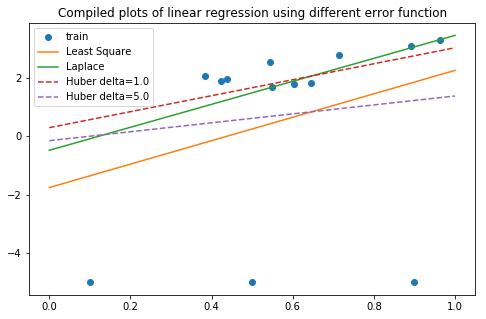

In [641]:
fig, ax = plt.subplots(figsize=(8,5))
train, = ax.plot(Xtrain, y, 'o',label='train')
ls, = ax.plot(np.linspace(0,1,10), w0_ls + w1_ls * np.linspace(0,1,10), label='Least Square')
la, = ax.plot(np.linspace(0,1,10), w0_la + w1_la * np.linspace(0,1,10), label='Laplace')
hu1, = ax.plot(np.linspace(0,1,10), w0_1 + w1_1 * np.linspace(0,1,10), '--',label='Huber delta=1.0')
hu2, = ax.plot(np.linspace(0,1,10), w0_2 + w1_2 * np.linspace(0,1,10), '--', label='Huber delta=5.0')


ax.legend(handles=[train, ls, la, hu1, hu2])
ax.set_title("Compiled plots of linear regression using different error function")
plt.show()

# Problem 2: Online training in linear regression

In [660]:
p2_data = loadmat("HW3_data/P2/P2.mat")
print(p2_data.keys())

dict_keys(['X', 'y'])


In [661]:
X = np.array(p2_data['X'])
y = np.array(p2_data['y'])

## Part A: Online learning

Online learning using the least mean squares error is performed below and the plots of error evolution and the fit are also presented

In [662]:
epoch_num = 60
w = np.array([0,0],dtype=float)
eta = 0.0001
err_record = []
for n in range(epoch_num):
    for i in range(y.shape[0]):
        r_i = (w[0] * X[i,0] + w[1] * X[i,1] - y[i,0])
        w[0] = w[0] - eta * r_i * X[i,0]
        w[1] = w[1] - eta * r_i * X[i,1]
    # calualte error
    err = np.sum([(w[0] * X[i,0] + w[1] * X[i,1] - y[i,0])**2 for i in range(y.shape[0])])
    err_record.append(err)

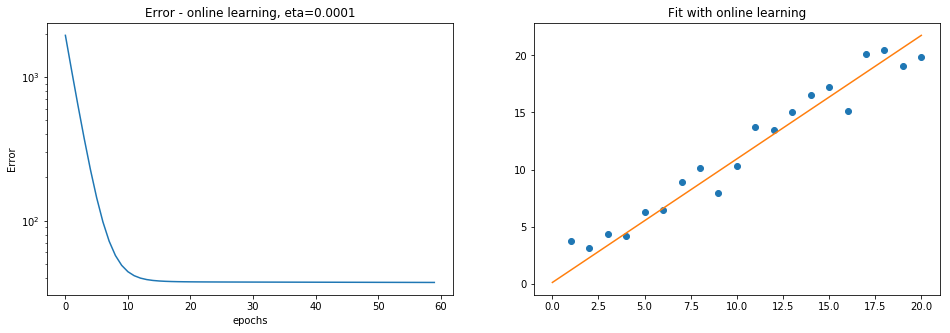

In [663]:
fig, axes = plt.subplots(ncols=2, figsize=(16,5))
axes[0].semilogy(err_record)
axes[0].set_xlabel('epochs')
axes[0].set_ylabel('Error')
axes[0].set_title("Error - online learning, eta={}".format(eta))

axes[1].plot(X[:,1], y[:,0], 'o')
axes[1].plot(np.linspace(0,20), w[0] + w[1]*np.linspace(0,20))
axes[1].set_title("Fit with online learning")
plt.show()

Online learning provides a good fit and the convergence plot shows that the solution continuously converge with a steady rate until reaching a plateau is reached. 

## Part B: Batch Learning with batch size of 5

In [668]:
epoch_num = 60
n = 5
w = np.array([0,0],dtype=float)
eta = 0.0001
err_record = []
for n in range(epoch_num):
    for i in range(0, y.shape[0], 5):
        dw0 = -eta * np.sum((w[0] * X[i:i+n, 0] + w[1] * X[i:i+n, 1] - y[i:i+n,0]) * X[i:i+n,0])
        dw1 = -eta * np.sum((w[0] * X[i:i+n, 0] + w[1] * X[i:i+n, 1] - y[i:i+n,0]) * X[i:i+n,1])
        w[0] = w[0] + dw0
        w[1] = w[1] + dw1
    # calualte error
    err = np.sum([(w[0] * X[i,0] + w[1] * X[i,1] - y[i,0])**2 for i in range(y.shape[0])])
    err_record.append(err)
print("final error level: {}".format(np.sqrt(err)/y.shape[0]))

final error level: 0.30469558256154106


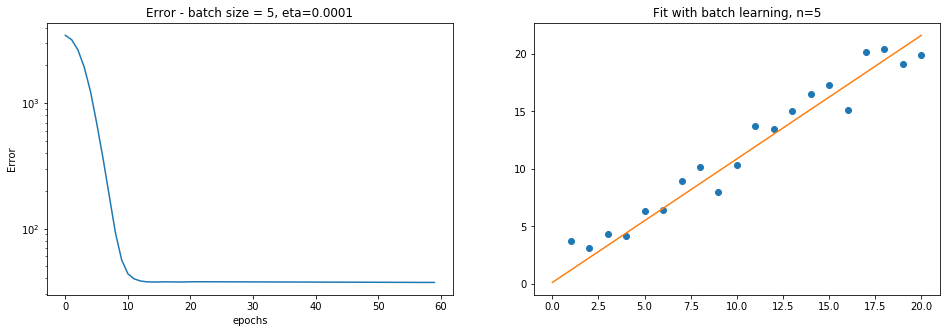

In [669]:
fig, axes = plt.subplots(ncols=2, figsize=(16,5))
axes[0].semilogy(err_record)
axes[0].set_xlabel('epochs')
axes[0].set_ylabel('Error')
axes[0].set_title("Error - batch size = 5, eta={}".format(eta))

axes[1].plot(X[:,1], y[:,0], 'o')
axes[1].plot(np.linspace(0,20), w[0] + w[1]*np.linspace(0,20))
axes[1].set_title("Fit with batch learning, n=5")
plt.show()

It can be observed that when batch learning is used, the error does not converge at a steady rate. Instead, there is an increasing rate of learning at the initial stage and it also has a much smoother transition to the plateau. 

# Problem 3: Least squares formalism to classification

## Part A

For the problem described above, evaluate the parameter matrix $\mathbf{W}$ by minimizing a sum-of-squares error function.

Given that $\mathbf{y}(\mathbf{x}) = \mathbf{W}\mathbf{x}$, the error is therefore defined as, 

$E_D(\mathbf{W}) = \frac{1}{2}\text{Tr}\{(\mathbf{W}\mathbf{x} - \mathbf{y})^T(\mathbf{W}\mathbf{x} - \mathbf{y})\}$ which then gives the solution through minimization,

$\mathbf{W} = (\mathbf{x}^T\mathbf{x})^{-1}\mathbf{x}^T\mathbf{y}$

## Part B: Compute decision boundary

In [670]:
#load data
p3_data = np.loadtxt('HW3_data/P3/P3', delimiter=' ')
X = p3_data[:,0:2]
y = p3_data[:,2:3]

The provided dataset is visualised through a quick scatter plot. 

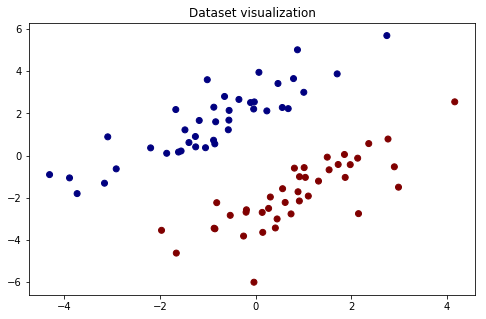

In [673]:
# visualize given data
fig, ax = plt.subplots(figsize=(8,5))
ax.scatter(X[:,0], X[:,1], c=y[:,0], cmap='jet')
ax.set_title("Dataset visualization")
plt.show()

In [687]:
# Construct classification problem
XX = np.concatenate([np.ones((X.shape[0],1)), X], axis=1)
YY = np.zeros((y.shape[0], 2))
for i in range(y.shape[0]):
    YY[i,int(y[i,0])] = 1
W = np.linalg.inv(XX.T @ XX) @ XX.T @ YY

Then, the decision boundary is obtained through 

$(\mathbf{w}_1 - \mathbf{w}_2)^T\mathbf{x} + w_{10} - w_{20} = 0$

It is implemented below in the code. 

In [689]:
# decision boundary
x_db = lambda x1: -((W[1,0]-W[1,1])*x1 + W[0,0] - W[0,1])/(W[2,0] - W[2,1])

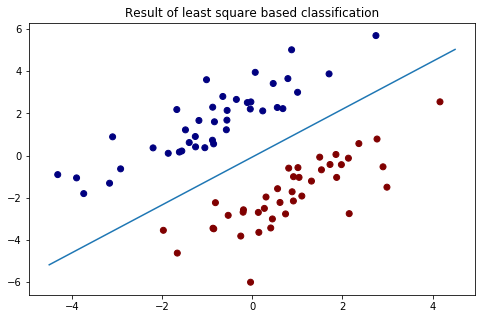

In [690]:
# Plot decision boundary
fig, ax = plt.subplots(figsize=(8,5))
ax.scatter(X[:,0], X[:,1], c=y[:,0], cmap='jet')
ax.plot(np.linspace(-4.5,4.5,100), x_db(np.linspace(-4.5,4.5,100)))
ax.set_title("Result of least square based classification")
plt.show()

From the plot above, it can be observed that the decision boundary successfully classified two classes.

# Problem 4: Logistic Regression for multiclass classification

## Part A
Show that for a linearly separable data set, the maximum likelihood solution for the logistic regression model is obtained by finding a vector w whose decision boundary wT φ (x) = 0 separates the classes and then taking the magnitude of w to infinity.

For logistic regression, the class probability is given as $p(C_k|\mathbf{x}) = \sigma(\mathbf{w}^T\mathbf{x})$, where $\sigma(a)$ is the sigmoid function. For a linearly separable data set, for example using a binary classification, class probability becomes,

$p(C_0|\mathbf{x}) = p(C_1|\mathbf{x}) = \sigma(\mathbf{w}^T\mathbf{x}) = 0.5$

which gives $\mathbf{w}^T\mathbf{x} = 0$

In addition, after we take derivative of the likelihood, we have, 

$\nabla E(\mathbf{w}) = \sum_{n=1}^N(y_n - t_n)\mathbf{x}_n = 0$

so we can arrive at the relation, 

$y_n = \sigma(\mathbf{w}^T\mathbf{x}_n) = t_n$

Therefore, $y_n$ can only be $0$ or $1$. In this case, the magnitude of $\mathbf{w}$ goes to infinity. 

## Part B
Show that the Hessian matrix H is positive definite. Hence show that the error function is a convex function of w and that it has a unique minimum.

To show the Hessian matrix is positive definite, we need to show that for any vector $\mathbf{u}$, $\mathbf{u}^T\mathbf{H}\mathbf{u}>0$.Proof as shown  below. 

$\begin{align}
\mathbf{u}^T\mathbf{H}\mathbf{u} &= \mathbf{u}^T\boldsymbol{\Phi}^T\mathbf{R}\boldsymbol{\Phi}\mathbf{u}\\
&= u_m\phi_m^n r_n \phi_m^n u_m \\
&= u_m^2 (\phi_m^n)^2 r_n > 0\ \ \text{(QED)}\end{align}$

## Part C
Write a code for implementing the iterative rewrighted least squares algorithm for logistic regression. Use this to find and plot the decision boundary corresponding to the data set given in this link. Compare the results with those obtained using least squares based classification.

First we load the data and have a quick plot of the dataset. We can see there are three classes. 

In [691]:
p4_data = np.loadtxt('HW3_data/P4/P4', delimiter=' ')
X = p4_data[:,:2]
y = p4_data[:,2:3]

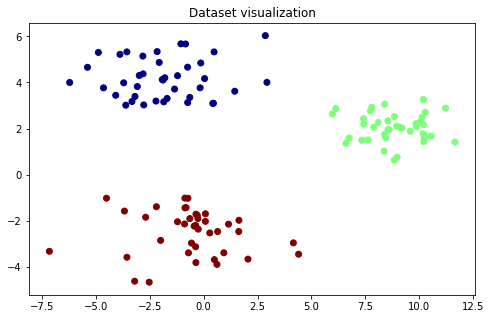

In [693]:
# Visualize data
fig, ax = plt.subplots(figsize=(8,5))
ax.scatter(X[:,0], X[:,1], c=y[:,0], cmap='jet')
ax.set_title("Dataset visualization")
plt.show()

In [698]:
# Construct IRLS
M = X.shape[1] + 1
K = 3
N = X.shape[0]
lam = 1e-8 # regularization coeff

Phi = np.concatenate([np.ones((N,1)),X],axis=1).T
T = np.zeros((N,K))
for i in range(y.shape[0]):
    T[i, int(y[i,0])] = 1

# Initialise W, Y, g and H
W = np.zeros((M,K))
Y = np.zeros(T.shape)
g = np.zeros((M,K))
H = np.zeros((M,M))

for n in range(N):
    denom = np.sum(np.exp(W.T @ Phi[:,n:n+1]))
    for k in range(K):
        Y[n,k] = np.squeeze(np.exp(W.T[k:k+1,:] @ Phi[:,n:n+1])) / denom


In [699]:
# start training
epochs = 1000
err_record = []
eta = 0.005
for epoch in range(epochs):
    # construct g
    for m in range(M):
        for k in range(K):
            g[m,k] = np.sum(Phi[m:m+1,:] @ (Y[:,k] - T[:,k]))
    # construct H
    for j in range(M):
        for k in range(M):
            if j == k:
                H[j,k] = np.sum((Y[:,j] - Y[:,j]**2) * Phi[j,:] * Phi[k,:])
            else:
                H[j,k] = np.sum((-Y[:,j] * Y[:,k]) * Phi[j,:] * Phi[k,:])
    # calcualte new w
    W = W - eta * np.linalg.inv(H) @ g
    # construct Y
    for n in range(N):
        denom = np.sum(np.exp(W.T @ Phi[:,n:n+1]))
        for k in range(K):
            Y[n,k] = np.squeeze(np.exp(W.T[k:k+1,:] @ Phi[:,n:n+1])) / denom
    # calculate err
    err = -np.sum(T * np.log(Y))
    err_record.append(err)
    #print("Iteration {}, Error = {}".format(epoch, err))

In [700]:
# Prepare for decision boundary visualization
x1, x2 = np.meshgrid(np.arange(-8, 13, 0.02), np.arange(-5, 7, 0.02))
grid_shape = x1.shape
grid_size = x1.size
prediction = np.argmax(np.exp((W.T @ np.concatenate([np.ones((grid_size, 1)), x1.reshape(grid_size,1), x2.reshape(grid_size,1)],axis=1).T)).T, axis=1).reshape(grid_shape)/3

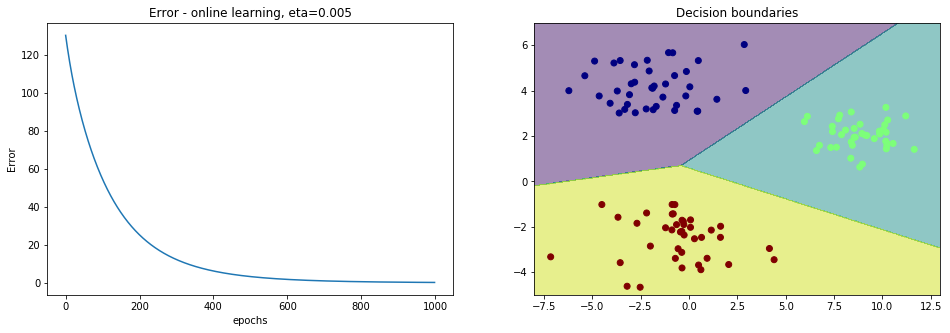

In [701]:
fig, axes = plt.subplots(ncols=2, figsize=(16,5))
axes[0].plot(err_record)
axes[0].set_xlabel('epochs')
axes[0].set_ylabel('Error')
axes[0].set_title("Error - online learning, eta={}".format(eta))

axes[1].contourf(x1, x2, prediction, alpha=0.5)
axes[1].scatter(X[:,0], X[:,1], c=y[:,0], cmap='jet')
axes[1].set_title("Decision boundaries")
plt.show()

It can be seen that three classes are correctly classified through the decision boundary. 

# Problem 5: Fishers Discriminant

## Part A
Show that maximization of the class separation criterion defined in Eq. 5 with respect to w, using a Lagrange multiplier to enforce the constraint wT w = 1, leads to the result that w ∝ (m2 − m1)

The idea is to maximize the class separation criterion with the constraint that $\mathbf{w}^T\mathbf{w}=1$, so we use Lagrange multiplier to obtain the objective function, 

$L = (m_2 - m_1) - \lambda(\sum_i^M w_i^2 - 1)$

Substitue equation (4) and (5) and take derivative with respect to $\mathbf{w}$, we obtain the required relation, 

$\mathbf{w} \propto (\mathbf{m}_2 - \mathbf{m}_1)$

## Part B
Show the Fisher Criterion can be written in the form of equation (7). 

The proof is shown below, 

$\begin{align}\mathbf{J}(\mathbf{w})&= \frac{(m_1 - m_2)^2}{s_1^2 + s_2^2}\\&= \frac{(\mathbf{w}^T\mathbf{m_1} - \mathbf{w}^T\mathbf{m_2})^2}{\sum_{n\in C_1}(\mathbf{w}^T\mathbf{x_n} - \mathbf{w}^T\mathbf{m_1})^2 + \sum_{n\in C_2}(\mathbf{w}^T\mathbf{x_n} - \mathbf{w}^T\mathbf{m_2})^2}\\
&=\frac{\mathbf{w}^T(\mathbf{m_1}-\mathbf{m_2})(\mathbf{m_1}-\mathbf{m_2})^T\mathbf{w}}{\mathbf{w}^T(\sum_{n\in C_1}(\mathbf{x_n}-\mathbf{m_1})(\mathbf{x_n}-\mathbf{m_1})^T + \sum_{n\in C_2}(\mathbf{x_n}-\mathbf{m_2})(\mathbf{x_n}-\mathbf{m_2})^T)\mathbf{w}}\\
&=\frac{\mathbf{w}^T\mathbf{S_B}\mathbf{w}}{\mathbf{w}^T\mathbf{S_W}\mathbf{w}}\ \ \text{(QED)}\end{align}$

## Part C
### a: Compute Fisher's vector

In [702]:
p5_data = loadmat("HW3_data/P5/P5.mat")
print(p5_data.keys())

dict_keys(['Xtrain', 'ytrain'])


In [703]:
Xtrain = np.array(p5_data['Xtrain']).T
#Xtrain = np.concatenate([np.ones((Xtrain.shape[0],1)), Xtrain],axis=1).T
ytrain = np.squeeze(np.array(p5_data['ytrain']))

In [704]:
print("Shape of Xtrain: {}".format(Xtrain.shape))
print("Shape of ytrain: {}".format(ytrain.shape))

Shape of Xtrain: (10, 528)
Shape of ytrain: (528,)


In [705]:
# get number of classes
K = np.max(ytrain)
M = Xtrain.shape[0]
N = Xtrain.shape[1]

Procedure to compute weights
1. Compute within-class and between class covariance
    $\mathbf{S}_W = \sum_{k=1}^K\mathbf{S}_k,\ \mathbf{S}_k = \sum_{n\in C_k}(\mathbf{x}_n - \mathbf{m}_k)(\mathbf{x}-\mathbf{m}_k)^T,\ \mathbf{m}_k = \frac{1}{N_k}\sum_{n\in C_k}\mathbf{x}_n$
    $\mathbf{S}_B = \sum_{k=1}^K N_k(\mathbf{m}_k-\mathbf{m})(\mathbf{m}_k-\mathbf{m})^T$
2. Weights can be obtained by $\mathbf{W} = \mathbf{S}_W^{-1/2}\mathbf{U}$ where $\mathbf{U}$ are the $D'$ leading eigenvectors of $\mathbf{S}_W^{-1/2}\mathbf{S}_B\mathbf{S}_W^{-1/2}$

In [706]:
# Calculate total mean
m = np.mean(Xtrain, axis=1).reshape(Xtrain.shape[0],1)
# calculate class mean
m_c = np.zeros((M,K))
k_count = np.zeros((1,K))
for i in range(N):
    k = ytrain[i]-1
    k_count[0,k] += 1
    m_c[:,k] = m_c[:,k] + Xtrain[:,i]
m_c = m_c/k_count

In [707]:
# Compute within-class covariance
S_W = np.zeros((M,M))
for i in range(N):
    k = ytrain[i]-1
    S_W += (Xtrain[:,i:i+1] - m_c[:,k:k+1]) @ (Xtrain[:,i:i+1] - m_c[:,k:k+1]).T

# Compute between-class covariance
S_B = np.zeros((M,M))
for k in range(K):
    S_B += k_count[0,k] * (m_c[:,k:k+1] - m) @ (m_c[:,k:k+1] - m).T

In [708]:
# Compute U
w,vr = linalg.eig(linalg.inv(linalg.sqrtm(S_W)) @ S_B @ linalg.inv(linalg.sqrtm(S_W)))

D = 2
U = vr[:,:D]

In [709]:
# Compute W
W = linalg.inv(linalg.sqrtm(S_W)) @ U

# Part B: Project to 2D and observe data

In [710]:
Y = W.T @ Xtrain

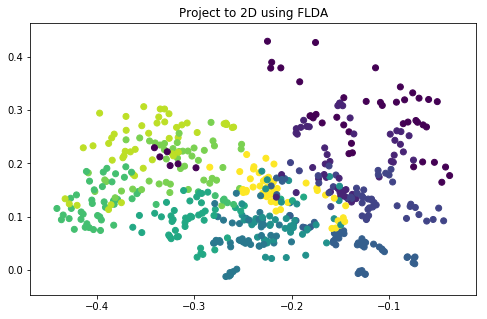

In [717]:
fig, ax = plt.subplots(figsize=(8,5))
ax.scatter(Y[0,:], Y[1,:], c=ytrain)
ax.set_title("Project to 2D using FLDA")
plt.show()

From the projected 2D data, it is difficult to identify the number of classes without showing the colors. However, the resulting 2D scatter resembles that from the PMTK example. 

# Problem 6: Bayesian logistic regression

## Part A: Gaussian approximation

Given the likelihood and prior, 

$p(\mathbf{t}|\mathbf{w}) = \prod_{n=1}^N y_n^{t_n}(1-y_n)^{1-t_n}$

$p(\mathbf{w}) = \mathcal{N}(\mathbf{w}|\mathbf{0},\mathbf{V_0})$

we can write the log-posterior as,

$\ln p(\mathbf{w}|\mathbf{t}) \propto -\frac{1}{2}\mathbf{w}\mathbf{V}_0^{-1}\mathbf{w} + \sum_{n=1}^N\{t_n\ln y_n + (1-t_n\ln (1-y_n)\} + \text{const}$

Fro Gaussian approximation, we obtain its MAP estimate by taking derivatives against $\mathbf{w}$, from which we obtain, 

$\mathbf{m}_{\text{map}} = \sum_{n=1}^N (y_n - t_n)\boldsymbol{\phi_n}\mathbf{V_0}$

Then the covariance is given by the inverse of the matrix of 2nd derivatives of the negative likelihood. 

$\mathbf{S}_N^{-1} = \mathbf{V_0}^{-1} + \sum_{n=1}^N y_n(1-y_n)\boldsymbol{\phi_n}\boldsymbol{\phi_n}^T$

Finally we obtain the *Gaussian approximation for the posterior*, 

$q(\mathbf{w}) = \mathcal{N}(\mathbf{w}|\mathbf{m}_\text{map}, \mathbf{S}_N)$

## Part B 
Provide an approximation for the posterior predictive using a Monte Carlo approximation as well as the probit approximation.

### MC Approximation

From the solution from Part A, the posterior predictive is presented as, 

$p(C_1|\boldsymbol{\phi},\mathbf{t}) = \int p(C_1|\boldsymbol{\phi},\mathbf{w})p(\mathbf{w}|\mathbf{t})d\mathbf{w} \approx \frac{1}{S}\sum_{s=1}^S \sigma(\mathbf{w}^{sT}\boldsymbol{\phi}(\mathbf{x}))$

where $\mathbf{w}^{s}\sim p(\mathbf{w}|\mathbf{t})$ from sampling. 

### Probit Approximation
By applying delta function and approximate the sigmoid function with the inverse probit function, we obtian the predictive posterior as, 

$p(C_1|\boldsymbol{\phi},\mathbf{t}) \approx \int \sigma(a)\mathcal{N}(a|\mu_a, \sigma_a^2) = \sigma(\kappa(\sigma_a^2)\mu),\ \ \kappa(\sigma^2) = (1+\frac{\pi\sigma^2}{8})^{-1/2}$

where 

$\sigma_a^2 = \boldsymbol{\phi}^T\mathbf{S}_N\boldsymbol{\phi}$

$\mu_a = \mathbf{w}_\text{map}^T \boldsymbol{\phi}$

## Part C
For the data set given in this link, write a code for computing the posterior based on the Laplace approximation. Plot the log-likelihood, log-unnormalized posterior and Laplace approximation to the posterior.

In [720]:
# Load data
p6_data = loadmat('HW3_data/P6/P6.mat')
print(p6_data.keys())

dict_keys(['X', 'Xgrid', 'alpha', 't'])


In [721]:
X = np.array(p6_data['X'])
Xgrid = np.array(p6_data['Xgrid'])
alpha = p6_data['alpha']
t = np.array(p6_data['t'])

M = X.shape[1]
N = X.shape[0]

In [722]:
print("Shape of X: {}".format(X.shape))
print("Shape of Xgrid: {}".format(Xgrid.shape))
print("Shape of t: {}".format(t.shape))

Shape of X: (60, 2)
Shape of Xgrid: (25921, 2)
Shape of t: (60, 1)


### Compute the posterior based on Laplace approximation
Use SGD for $\mathbf{m}_{\text{map}}$, then we can obtain the covariance and the posterior as,

$\mathbf{S}_N^{-1} = \mathbf{V_0}^{-1} + \sum_{n=1}^N y_n(1-y_n)\boldsymbol{\phi_n}\boldsymbol{\phi_n}^T$

$q(\mathbf{w}) = \mathcal{N}(\mathbf{w}|\mathbf{m}_\text{map}, \mathbf{S}_N)$

MAP estimate of m is obtained through root finding. 

In [723]:
epochs = 2000
eta = 0.0005
w = np.ones((2,1))
err_record = []
p_record = []

for epoch in range(epochs):
    y = 1/(1+np.exp(-X @ w))
    g = w/alpha + np.sum([(y[i,0] - t[i,0]) * X[i:i+1,:].T for i in range(N)], axis=0)
    #HV = 1/alpha + np.sum([y[i,0] * (1-y[i,0]) * (X[i:i+1,:].T @ X[i:i+1]) for i in range(N)], axis=0)
    w = w - eta * g
    err = 1/2 * np.squeeze(w.T @ w) /alpha - np.sum([t[i,0] * np.log(y[i,0]) + (1-t[i,0])*np.log(1-y[i,0]) for i in range(N)])
    err_record.append(err)

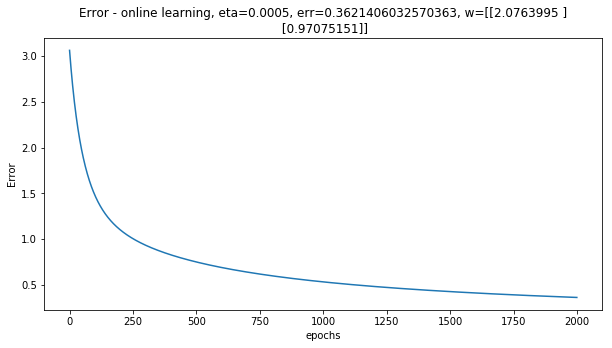

In [724]:
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(err_record)
ax.set_xlabel('epochs')
ax.set_ylabel('Error')
ax.set_title("Error - online learning, eta={}, err={}, w={}".format(eta, err, w))
plt.show()

In [725]:
m_map = w.copy()
y = 1/(1+np.exp(-X@m_map))
S_N = linalg.inv(1/alpha + np.sum([y[i,0] * (1-y[i,0]) * X[i:i+1,:].T @ X[i:i+1] for i in range(N)], axis=0))

The log-likelihood, log-unnormalized posterior and Laplace approximation to the posterior are then obtained as,

$\ln p(\mathbf{t}|\mathbf{w}) = \sum_{n=1}^N\{t_n\ln y_n + (1-t_n)\ln (1-y_n)\}$

$\ln p(\mathbf{w}|\mathbf{t}) \propto -\frac{1}{2}\mathbf{w}\mathbf{V}_0^{-1}\mathbf{w} + \sum_{n=1}^N\{t_n\ln y_n + (1-t_n)\ln (1-y_n)\} + \text{const.}$

$q(\mathbf{w}) = \mathcal{N}(\mathbf{w}|\mathbf{m}_\text{map}, \mathbf{S}_N)$

In [726]:
Nw = 100
w1, w2 = np.meshgrid(np.linspace(-8,8,Nw), np.linspace(-8,8,Nw))
ll = np.zeros((Nw, Nw)) # Log-likelihood
ln = np.zeros((Nw, Nw)) # log unnormalized posterior
la = np.zeros((Nw, Nw)) # posterior with laplace approximation

In [727]:
for i in range(Nw):
    for j in range(Nw):
        w = np.array([[w1[i,j]],[w2[i,j]]])
        y = 1/(1+np.exp(-X @ w))
        ll[i,j] = np.sum([t[i,0] * np.log(y[i,0]) + (1-t[i,0])* np.log(1-y[i,0]) for i in range(N)])
        ln[i,j] = -1/2 * 1/alpha * w.T @ w +  np.sum([t[i,0] * np.log(y[i,0]) + (1-t[i,0])* np.log(1-y[i,0]) for i in range(N)])
        la[i,j] = -1/2 * (w - m_map).T @ linalg.inv(S_N) @ (w - m_map)

/Users/senwang/miniconda3/envs/basemap/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """
/Users/senwang/miniconda3/envs/basemap/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  
/Users/senwang/miniconda3/envs/basemap/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in multiply
  """
/Users/senwang/miniconda3/envs/basemap/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in multiply
  


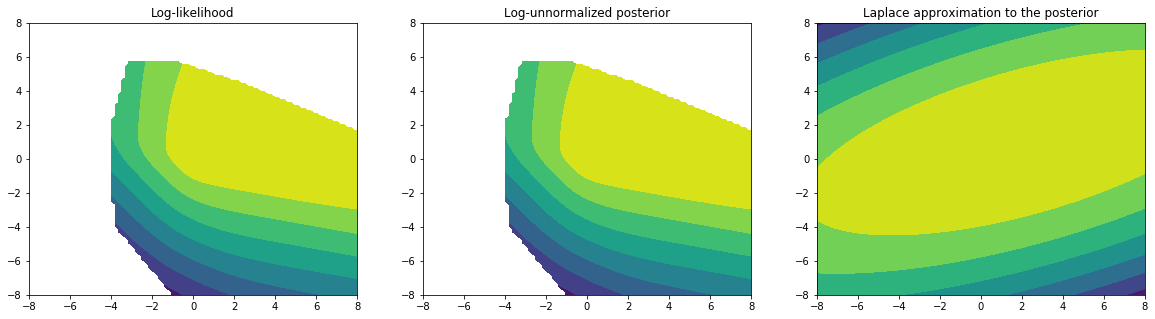

In [729]:
fig, axes = plt.subplots(ncols=3, figsize=(20,5))
axes[0].contourf(w1, w2, ll)
axes[0].set_title("Log-likelihood")
axes[1].contourf(w1, w2, ln)
axes[1].set_title("Log-unnormalized posterior")
axes[2].contourf(w1, w2, la)
axes[2].set_title("Laplace approximation to the posterior")
plt.show()

The white region and the warning shown above is due to $y$ value when $a=\mathbf{w}^T\mathbf{x} << 0$, which gives $\ln(1-y_n) = \ln(0)$

## Part D
Write a code for computing the posterior predictive distribution using MC approximation. Draw samples from the posterior predictive distribution and compute average over the samples. Recompute the posterior using probit approximation and compare the results.

In [584]:
Nx = 100
x1, x2 = np.meshgrid(np.linspace(-8,8,Nw), np.linspace(-8,8,Nw))
XX = np.concatenate([x1.reshape(Nx*Nx,1),x2.reshape(Nx*Nx,1)], axis=1)

### MC approximation

In [586]:
# Draw samples of w for MC approximation
from scipy.stats import multivariate_normal
mc_size = 20
w_mc = multivariate_normal.rvs(mean=m_map[:,0], cov=S_N, size=mc_size)
p_mc = np.zeros((Nw, Nw))
for i in range(mc_size):
    p_mc += 1/(1+np.exp(-XX @ w_mc[i,:].reshape(2,1)).reshape(Nw,Nw))
p_mc = p_mc/mc_size

### Probit Approximation
$p(C_1|\boldsymbol{\phi},\mathbf{t}) \approx \int \sigma(a)\mathcal{N}(a|\mu_a, \sigma_a^2) = \sigma(\kappa(\sigma_a^2)\mu),\ \ \kappa(\sigma^2) = (1+\frac{\pi\sigma^2}{8})^{-1/2}$

where 

$\sigma_a^2 = \boldsymbol{\phi}^T\mathbf{S}_N\boldsymbol{\phi}$

$\mu_a = \mathbf{w}_\text{map}^T \boldsymbol{\phi}$

In [600]:
p_pb = np.zeros((Nx,Nx))
for i in range(Nw):
    for j in range(Nw):
        x = np.array([[x1[i,j]],[x2[i,j]]])
        mu_a = np.squeeze(m_map.T @ x)
        sigma_a2 = np.squeeze(x.T @ S_N @ x)
        a = (1+np.pi * sigma_a2/8)**(-1/2) * mu_a
        p_pb[i,j] = 1/(1+np.exp(-a))

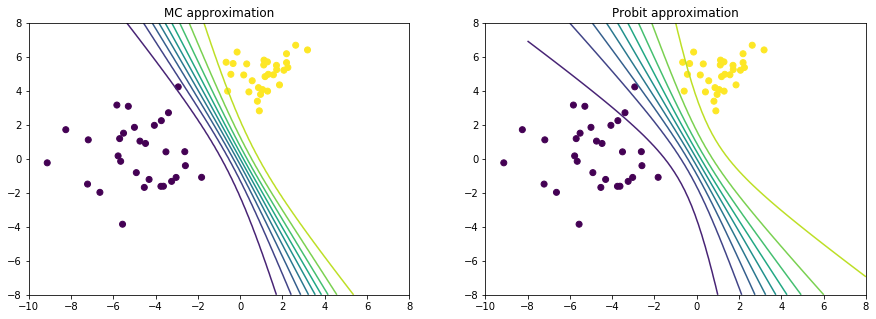

In [602]:
fig, axes = plt.subplots(ncols=2, figsize=(15,5))
axes[0].scatter(X[:,0],X[:,1],c=t[:,0])
axes[0].contour(x1, x2, p_mc, levels=10)
axes[0].set_title("MC approximation")

axes[1].scatter(X[:,0],X[:,1],c=t[:,0])
axes[1].contour(x1, x2, p_pb, levels=10)
axes[1].set_title("Probit approximation")
plt.show()

It can be observed from the plots above, that both approximation gives a pretty good result in classfication, but the MC approximation has smaller variance of the decision boundary as compared to that of the probit approximation. 